#  Amazon Apparel Recommendations


In [1]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_json("tops_fashion.json")

In [3]:
data.head()

,sku,asin,product_type_name,formatted_price,author,color,brand,publisher,availability,reviews,large_image_url,availability_type,small_image_url,editorial_review,title,model,medium_image_url,manufacturer,editorial_reivew
0,None,B016I2TS4W,SHIRT,None,None,None,FNC7C,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Women's O Nec...,Minions Como Superheroes Ironman Long Sleeve R...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
1,None,B01N49AI08,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Izo Tunic,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
2,None,B01JDPCOHO,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Won Top,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
3,None,B01N19U5H5,SHIRT,None,None,None,Focal18,None,None,"[True, https://www.amazon.com/reviews/iframe?a...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,100% Brand New & Fashion<br> Quantity: 1 Piece...,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
4,None,B004GSI2OS,SHIRT,$26.26,None,Onyx Black/ Stone,FeatherLite,None,Usually ships in 6-10 business days,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,,Featherlite Ladies' Long Sleeve Stain Resistan...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN


In [4]:
print("no. of rows",data.shape[0])

no. of rows 183138


In [5]:
print("no. of columns",data.shape[1])

no. of columns 19


In [6]:
print(data.columns)

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')


In [7]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [8]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


In [9]:
print("no. of columns",data.shape[1])

no. of columns 7


In [10]:
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [11]:
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [12]:
from collections import Counter

In [13]:
product_count=Counter(list(data['product_type_name']))
product_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

In [14]:
data['brand'].describe()

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object

In [15]:
data['brand'].unique()

array(['FNC7C', 'FIG Clothing', 'Focal18', ..., 'Z', "Rain's Pan Jacket",
       'FFLMYUHULIU'], dtype=object)

In [16]:
data['color'].describe()

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object

In [17]:
data['color'].unique()

array([None, 'Onyx Black/ Stone', 'Grape', ..., 'Combo C',
       'White, Soft Coral and Charcoal Varigated', 'Monochrome Plaid'],
      dtype=object)

In [18]:
color_count=Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

In [19]:
 data['formatted_price'].describe()

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object

In [20]:
data['formatted_price'].unique()

array([None, '$26.26', '$9.99', ..., '$16.05', '$88.29', '$28.05'],
      dtype=object)

In [21]:
price_count=Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

In [22]:
data['title'].describe()

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object

In [23]:
data['title'].unique()

array(['Minions Como Superheroes Ironman Long Sleeve Round Neck T-Shirt For Women',
       'FIG Clothing Womens Izo Tunic', 'FIG Clothing Womens Won Top',
       ...,
       'Wrangler George Strait For Her Long Sleeve Pink Print Western Shirt',
       'Susana Monaco Womens Susana Monoco Sleeveless Smock Top, 6, Pink',
       "SexyBaby Women's Mesh Splive Flounced Sleeve Crew Neck Tops Blouses"],
      dtype=object)

In [24]:
title_count=Counter(list(data['title']))
title_count.most_common(10)

[('Nakoda Cotton Self Print Straight Kurti For Women', 77),
 ("Q-rious Women's Racerback Cotton Lycra Camsioles", 56),
 ('FINEJO Casual Women Long Sleeve Lace Irregular Hem Blouse Tops', 47),
 ('Girlzwalk Women Cami Sleeveless Printed Swing Vest Top Plus Sizes', 44),
 ("ELINA FASHION Women's Indo-Western Tunic Top Cotton Kurti", 43),
 ('Victoria Scoop Neck Front Lace Floral High-Low Top in 4 Sizes', 40),
 ("Cenizas Women's Indian Tunic Top Cotton Kurti", 39),
 ('Indistar Womens Premium Cotton Half Sleeves Printed T-Shirts/Tops (Pack of 3)',
  37),
 ("Rajnandini Women's Cotton Printed Kurti", 35),
 ('Long Sleeve Mock Neck Top', 32)]

In [25]:
data.to_pickle('180k_data')

In [26]:
data=pd.read_pickle("180k_data")
data

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
...,...,...,...,...,...,...,...
183133,B01MSALTSO,TOOGOO(R),Black,https://images-na.ssl-images-amazon.com/images...,OUTERWEAR,TOOGOO(R) Women's Tops Spring Autumn Casual Pu...,$14.58
183134,B015W98YQK,VOGUE CODE,Monochrome Plaid,https://images-na.ssl-images-amazon.com/images...,SHIRT,VOGUE CODE Vintage V Neck Plaid Shirt Sleevele...,None
183135,B075756PGC,Wrangler,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Wrangler George Strait For Her Long Sleeve Pin...,None
183136,B074L8FVTT,susana monaco,Rose,https://images-na.ssl-images-amazon.com/images...,SHIRT,Susana Monaco Womens Susana Monoco Sleeveless ...,$44.99


In [27]:
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28395


In [28]:
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 28385


In [29]:
data.to_pickle('28k_apparel_data')

In [30]:
data = pd.read_pickle('28k_apparel_data')
data

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
11,B001LOUGE4,Fitness Etc.,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Ladies Cotton Tank 2x1 Ribbed Tank Top,$11.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
21,B014ICEDNA,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel Short...,$7.50
...,...,...,...,...,...,...,...
183110,B073YGRLSM,Sky and Sparrow,Rose,https://images-na.ssl-images-amazon.com/images...,SHIRT,"SKY AND SPARROW Grommet Lace Up Top, Rose, Small",$26.99
183120,B01NCO06S0,Faded Glory,Blue/Grey,https://images-na.ssl-images-amazon.com/images...,SHIRT,Faded Glory Women's Plaid Button Down 2 Pocket...,$18.99
183124,B01AVN150E,Sacred Threads,Multi,https://images-na.ssl-images-amazon.com/images...,SHIRT,Printed Top in Assorted Colors – One size #215...,$22.00
183133,B01MSALTSO,TOOGOO(R),Black,https://images-na.ssl-images-amazon.com/images...,OUTERWEAR,TOOGOO(R) Women's Tops Spring Autumn Casual Pu...,$14.58


In [31]:
print(" no. of duplicates titles :-",sum(data.duplicated("title")))

 no. of duplicates titles :- 2325


In [32]:
data_sorted=data[data['title'].apply(lambda a:len(a.split(" "))) > 4]
print("remove title which have len less then 4")

remove title which have len less then 4


In [33]:
data_sorted.sort_values("title",inplace=True,ascending = False)
data_sorted.head(10)

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32
152506,B00WOB0LHK,xiaoming,Red+Grey,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Plaid Checked Casual Tops Shir...,$15.38
76209,B014GZY5KK,xiaoming,Figure Color,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Shirt Black Blouse Casual Oversized W...,$26.15
103647,B00WPJHEE4,xiaoming,Yellow,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Casual Women Long Loose Sleeve Shirt ...,$19.12
138588,B00X5MLMRA,xiaoming,Yellow,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Casual Sleeve Womens Shirt Lace Chiff...,$11.65
95954,B00WPK4T4G,xiaoming,red+whtie,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Blazer Womens Style Cape Hippie Loose...,$17.05


In [34]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [35]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i


    a = data['title'].loc[indices[i]].split()
    j = i+1
    while j < num_data_points:

       
        b = data['title'].loc[indices[j]].split()
        length = max(len(a), len(b))

        count  = 0

        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

    
        if (length - count) > 2:
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [36]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [37]:
print('Number of data points : ', data.shape[0])

Number of data points :  17592


In [38]:
data.to_pickle('17k_apperal_data')

In [39]:
data = pd.read_pickle('17k_apperal_data')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel O Nec...,$7.39
43,B0079BMKDS,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,APPAREL,Featherlite Ladies' Silky Smooth Pique (White)...,$13.53


In [40]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    for j in indices:
        
        b = data['title'].loc[j].split()
        
        length = max(len(a),len(b))
        count  = 0

     
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1
        if (length - count) < 3:
            indices.remove(j)

In [41]:
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [42]:
print('Number of data points after stage two of dedupe: ',data.shape[0])


Number of data points after stage two of dedupe:  16434


In [43]:
data.to_pickle('16k_apperal_data')

## text preprocessing

In [44]:
data = pd.read_pickle('16k_apperal_data')
data

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel O Nec...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Fifth Degree Womens Gold Foil Graphic Tees Jun...,$6.95
...,...,...,...,...,...,...,...
183081,B01MRV2IFS,YueLian,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,YueLian Women's Chiffon Short Sleeves Sun Prot...,$19.25
183092,B01LY4QWLF,Vintage America,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Vintage America Women's Large Lace Up Collared...,$23.24
183096,B07167SCNH,Tart Collections,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,"Tart Womens Collections Ann Wrap Top, Xs, Black",$29.99
183101,B07575N2WX,Soprano,Gray,https://images-na.ssl-images-amazon.com/images...,SHIRT,Soprano Womens Small Tie-Fringe Slub-Knit Tank...,$22.83


In [45]:
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'through', 'all', 'during', 'than', 'at', 'so', 'doing', 'to', 'why', 'on', 'he', "you've", 'over', "mightn't", 'in', 'any', 'can', 'the', 'only', 'ours', 'just', 're', 'needn', 'theirs', 'wasn', 'these', 'more', 'wouldn', 'were', 'with', 'me', 'down', 'own', 'when', 'didn', 'and', 'ourselves', 'himself', 'whom', 'from', 'before', 'some', 'isn', 'will', 'an', 'not', 'other', 'our', 've', 'be', 'their', "hadn't", 'll', 'that', 'where', 'won', 'i', 'very', 't', 'themselves', "shouldn't", "doesn't", 'no', 'y', 'having', 'ain', 'of', 'your', 'it', 'by', "needn't", 'd', 'should', 'her', 'against', "weren't", 'weren', "you'll", 'both', 'or', "should've", 'they', 'again', "won't", 'between', 'further', 'was', 'yourselves', 'such', 'herself', 'what', 'if', 'because', 'now', 'who', 'is', 'm', "hasn't", 'had', 'as', 'shouldn', 'while', 'doesn', "it's", 'few', 'aren', 'same', 'how', 'have', 'above', "you're", 'into', 'off', 'ma', 'out', "didn't", 'has', 'nor', 'its', 'this', 

In [46]:
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')

In [47]:
data.to_pickle('16k_apperal_data_preprocessed')

## stemming

In [48]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))

argu
fish


## Text based product similarity

In [50]:
data = pd.read_pickle('16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [51]:
def display_img(url,ax,fig):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        ax = plt.subplot(gs[0])
    
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) 
        ax.set_title(text) 
       
        ax = plt.subplot(gs[1])

        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        display_img(url, ax, fig)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    intersection = set(vec1.keys()) & set(vec2.keys()) 

    
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

            
    keys = list(vec2.keys())
   
    values = [vec2[x] for x in vec2.keys()]
    


    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
           
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)

def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
   
    return Counter(words) 



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    vector1 = text_to_vector(text1)

    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

## Bag of Words (BoW) on product titles

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(16434, 12684)

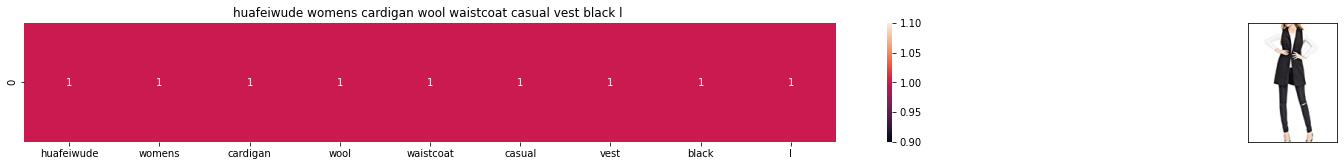

ASIN : B01MT96PXZ
Brand: Huafeiwude
Title: huafeiwude womens cardigan wool waistcoat casual vest black l 
Euclidean similarity with the query image : 0.0


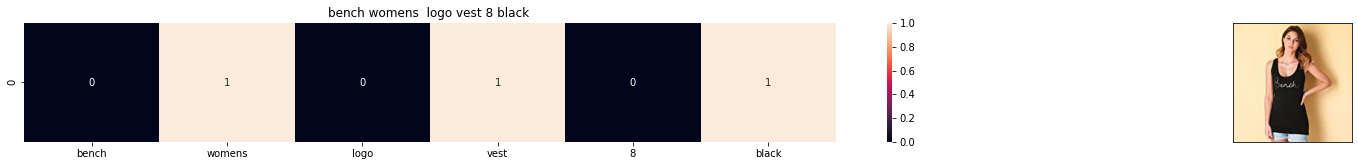

ASIN : B01MXMPTAD
Brand: Bench
Title: bench womens  logo vest 8 black 
Euclidean similarity with the query image : 2.6457513110645907


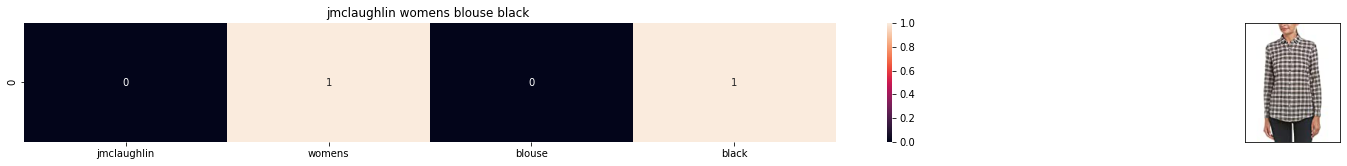

ASIN : B074KN55WS
Brand: J. McLaughlin
Title: jmclaughlin womens blouse black 
Euclidean similarity with the query image : 2.8284271247461903


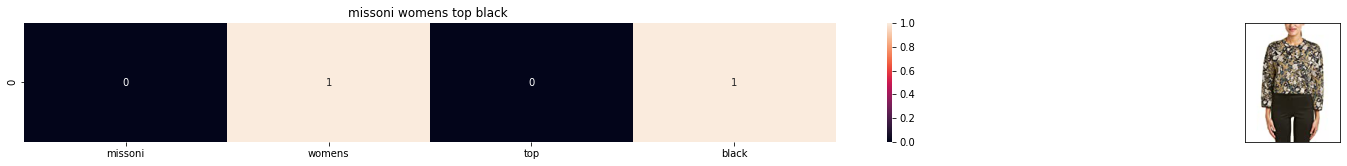

ASIN : B074TSFJHM
Brand: M Missoni
Title: missoni womens top black 
Euclidean similarity with the query image : 2.8284271247461903


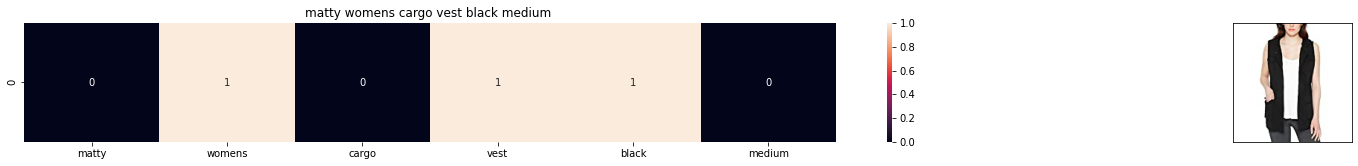

ASIN : B01LXQ055O
Brand: Matty M
Title: matty womens cargo vest black medium 
Euclidean similarity with the query image : 2.8284271247461903


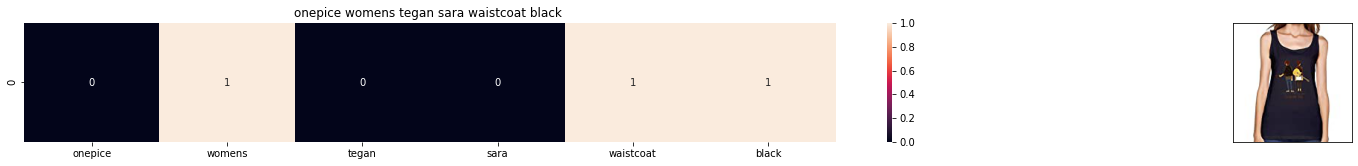

ASIN : B01EF0WPFI
Brand: ONEPICE
Title: onepice womens tegan sara waistcoat black 
Euclidean similarity with the query image : 2.8284271247461903


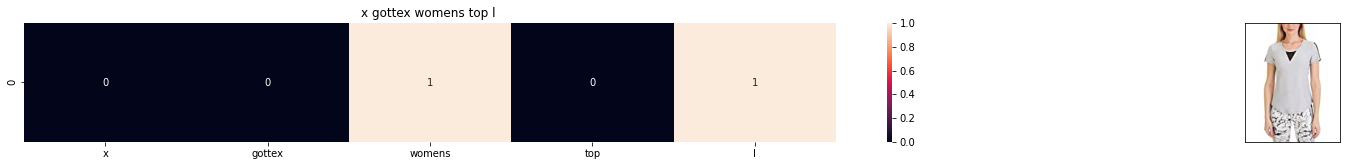

ASIN : B073M78XLP
Brand: X by Gottex
Title: x gottex womens top l 
Euclidean similarity with the query image : 3.0


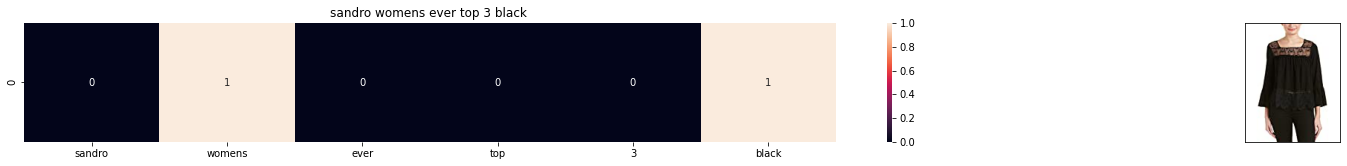

ASIN : B06XKX3BZL
Brand: Sandro
Title: sandro womens ever top 3 black 
Euclidean similarity with the query image : 3.0


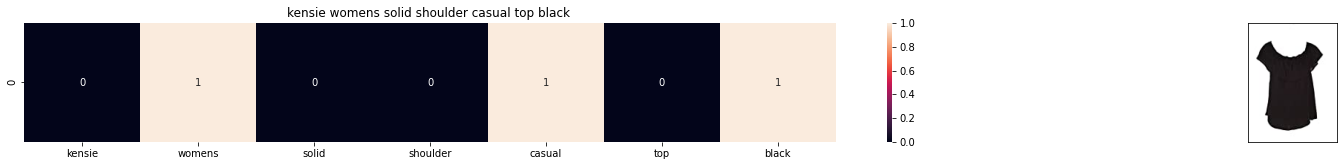

ASIN : B072HLFGT5
Brand: kensie
Title: kensie womens solid shoulder casual top black 
Euclidean similarity with the query image : 3.0


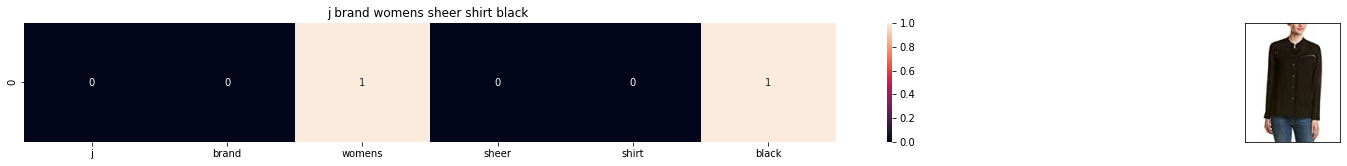

ASIN : B013L1V8PK
Brand: J Brand Jeans
Title: j brand womens sheer shirt black 
Euclidean similarity with the query image : 3.0


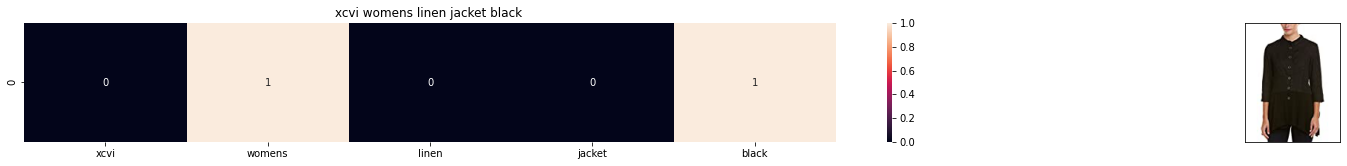

ASIN : B01M31Q4Z0
Brand: XCVI
Title: xcvi womens linen jacket black 
Euclidean similarity with the query image : 3.0


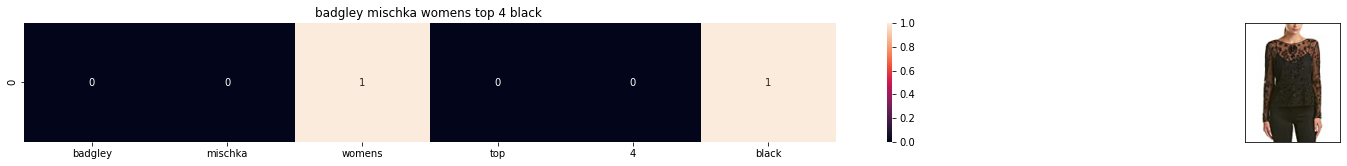

ASIN : B074TWLMJ8
Brand: Badgley Mischka
Title: badgley mischka womens top 4 black 
Euclidean similarity with the query image : 3.0


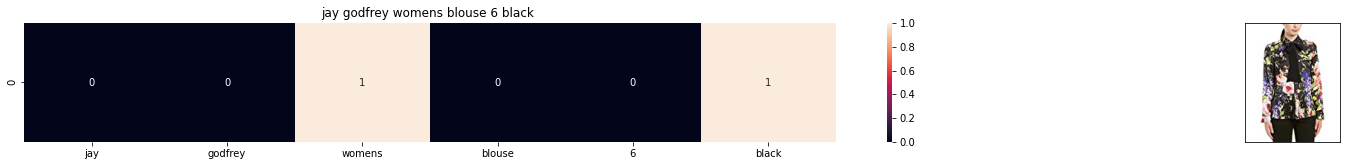

ASIN : B075B1NXKV
Brand: Jay Godfrey
Title: jay godfrey womens blouse 6 black 
Euclidean similarity with the query image : 3.0


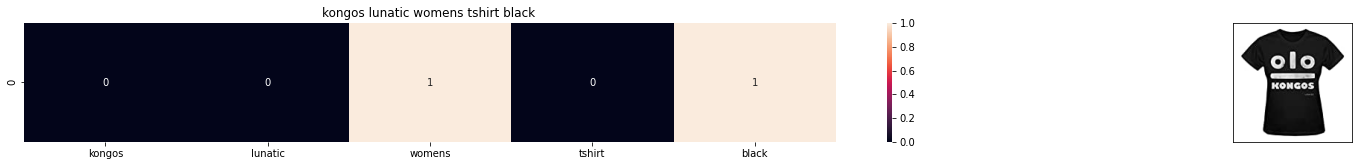

ASIN : B01IXZLJIA
Brand: Moonflow
Title: kongos lunatic womens tshirt black 
Euclidean similarity with the query image : 3.0


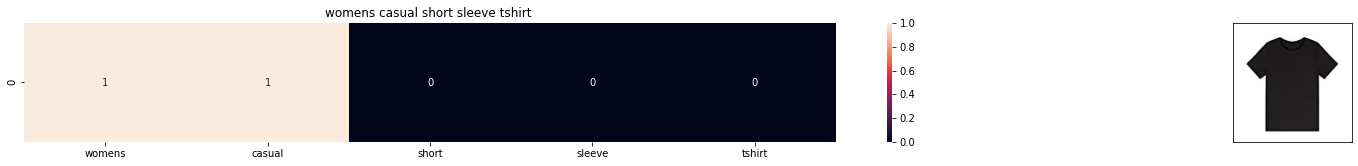

ASIN : B074T9KG9Q
Brand: Rain
Title: womens casual short sleeve tshirt 
Euclidean similarity with the query image : 3.0


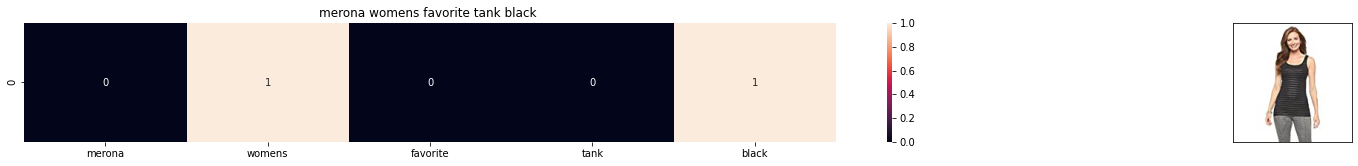

ASIN : B01KBGZE4Y
Brand: Merona
Title: merona womens favorite tank black 
Euclidean similarity with the query image : 3.0


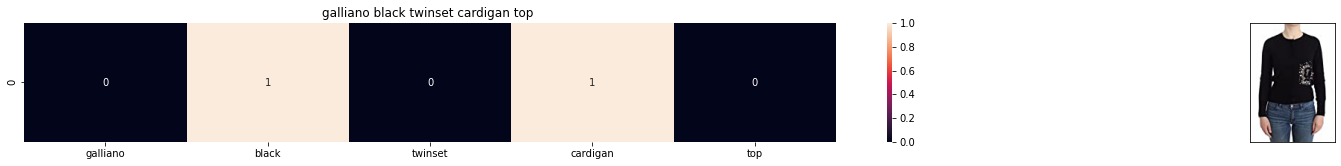

ASIN : B074G57HQJ
Brand: Galliano
Title: galliano black twinset cardigan top 
Euclidean similarity with the query image : 3.0


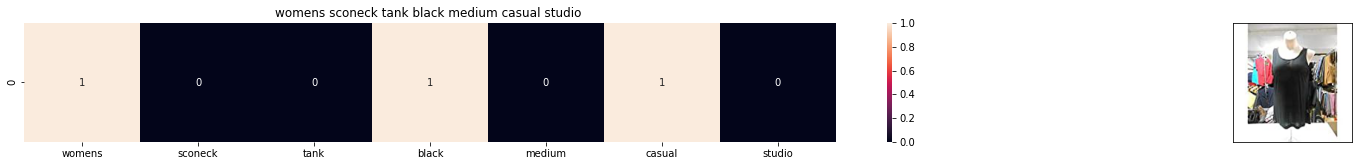

ASIN : B06ZZCKDQW
Brand: Casual Studio
Title: womens sconeck tank black medium casual studio 
Euclidean similarity with the query image : 3.0


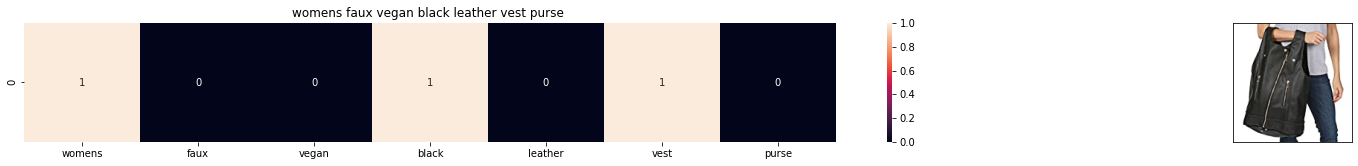

ASIN : B01M34NPAM
Brand: WHAT ON EARTH
Title: womens faux vegan black leather vest purse 
Euclidean similarity with the query image : 3.0


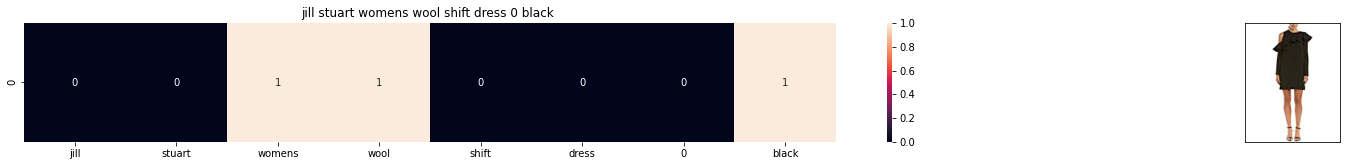

ASIN : B07591PX36
Brand: Jill Stuart
Title: jill stuart womens wool shift dress 0 black 
Euclidean similarity with the query image : 3.0


In [56]:
def bag_of_words_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
   
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
bag_of_words_model(12566, 20) 


## TF-IDF based product similarity

In [54]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

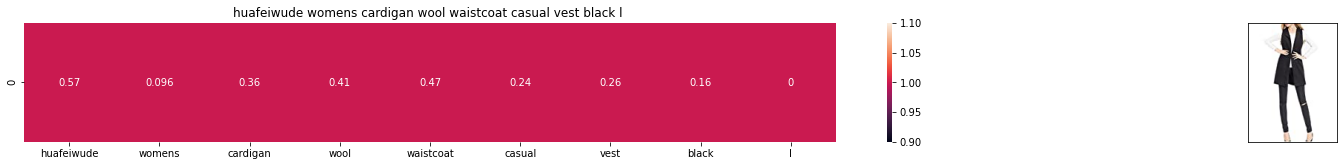

ASIN : B01MT96PXZ
BRAND : Huafeiwude
Eucliden distance from the given image : 0.0


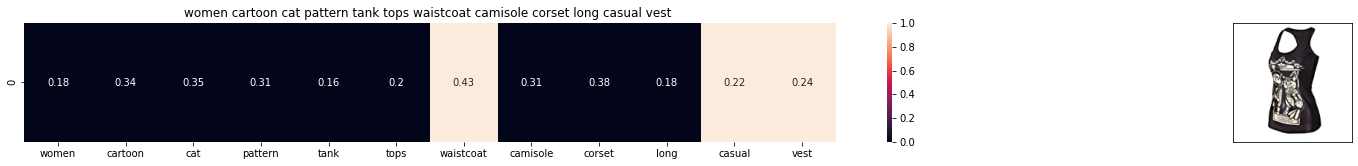

ASIN : B011R13YBM
BRAND : Huayang
Eucliden distance from the given image : 1.1722779213868202


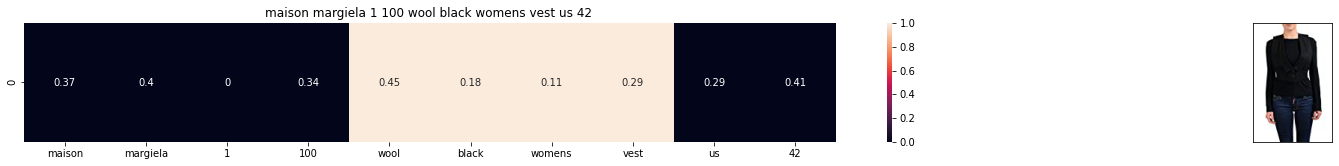

ASIN : B01N58BIEH
BRAND : Maison Margiela
Eucliden distance from the given image : 1.1859602292161415


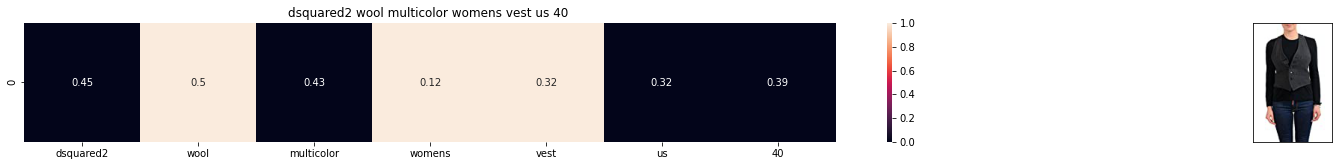

ASIN : B01N2MU4DR
BRAND : DSQUARED2
Eucliden distance from the given image : 1.188600377321188


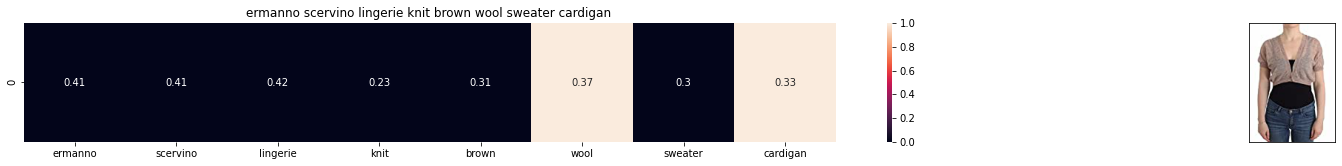

ASIN : B074G59T11
BRAND : ERMANNO SCERVINO
Eucliden distance from the given image : 1.206359485845001


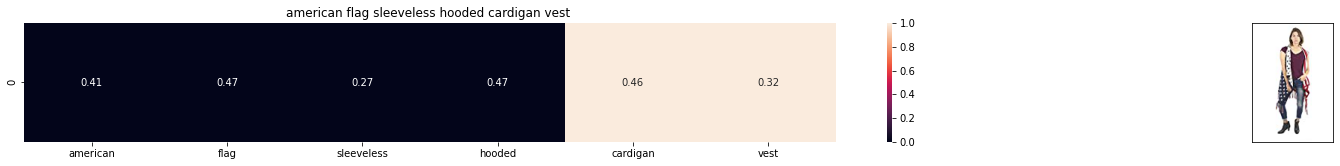

ASIN : B01MF523XO
BRAND : A&O International
Eucliden distance from the given image : 1.225015799943407


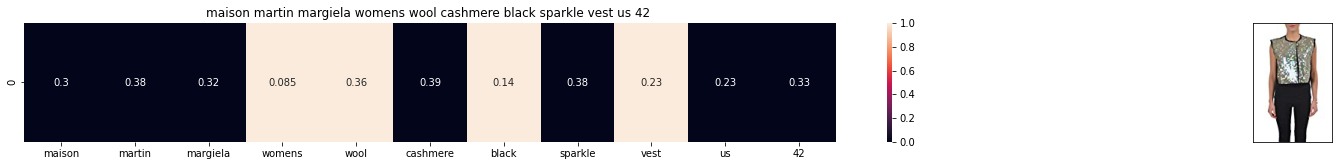

ASIN : B0175G7C20
BRAND : Maison Martin Margiela
Eucliden distance from the given image : 1.2351958567475707


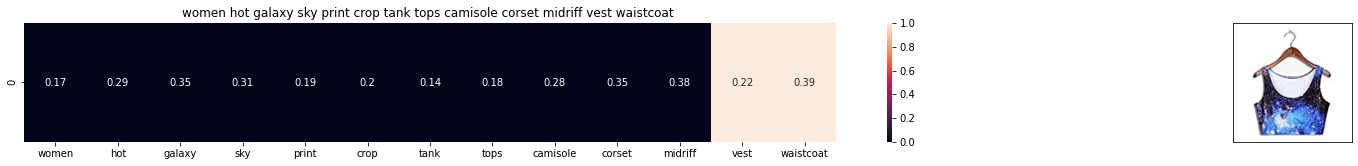

ASIN : B011R13I5Y
BRAND : Huayang
Eucliden distance from the given image : 1.236015538222882


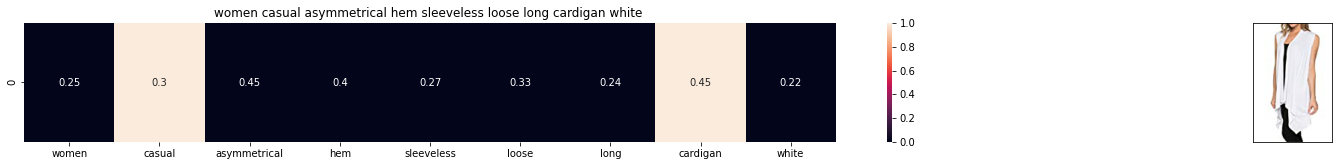

ASIN : B019V3MIP6
BRAND : KingField
Eucliden distance from the given image : 1.2364678792669093


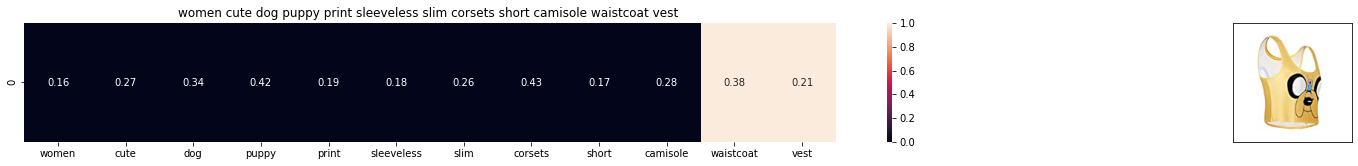

ASIN : B011R13T2Q
BRAND : Huayang
Eucliden distance from the given image : 1.2395445383327484


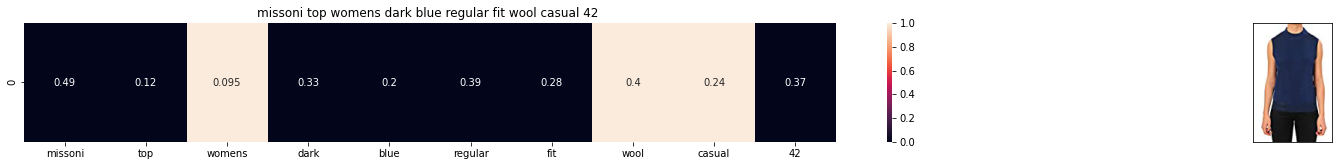

ASIN : B06XY144C5
BRAND : Missoni
Eucliden distance from the given image : 1.2415915469686623


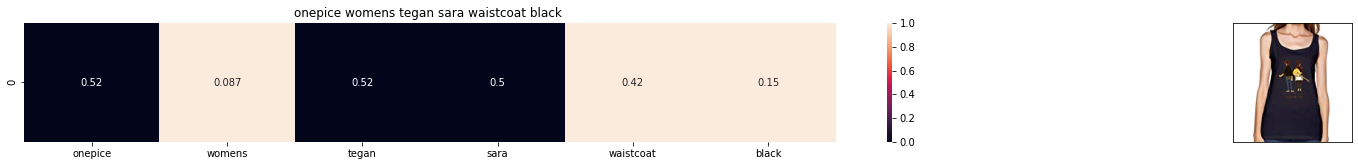

ASIN : B01EF0WPFI
BRAND : ONEPICE
Eucliden distance from the given image : 1.2416544379264938


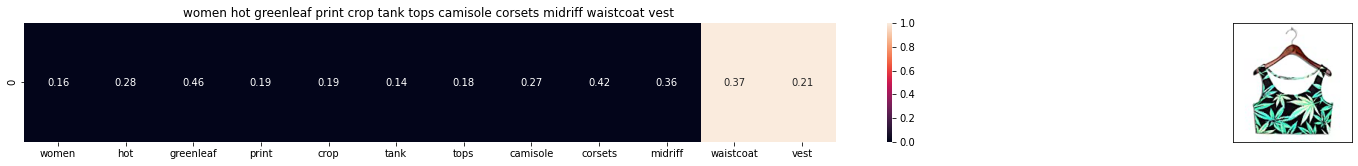

ASIN : B011R13OVW
BRAND : Huayang
Eucliden distance from the given image : 1.2428237398407325


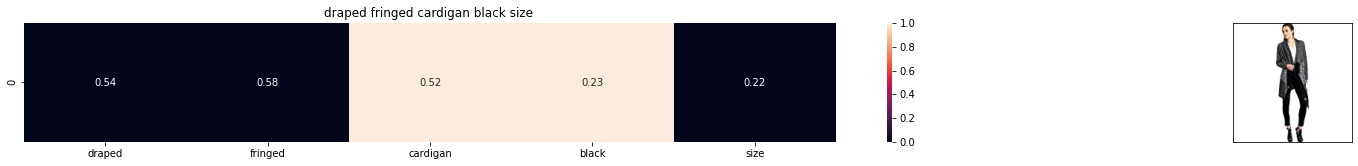

ASIN : B01CB33866
BRAND : Flying Tomato
Eucliden distance from the given image : 1.2439474778333672


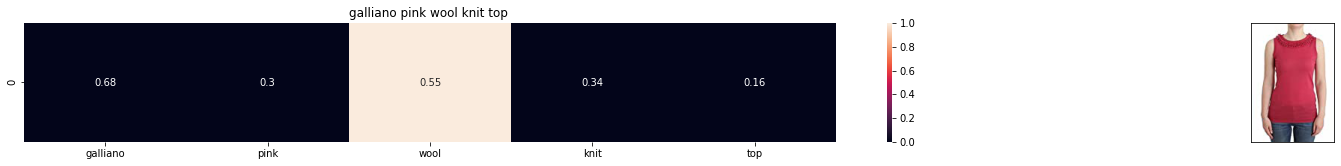

ASIN : B074G4V6NJ
BRAND : Galliano
Eucliden distance from the given image : 1.246074624114252


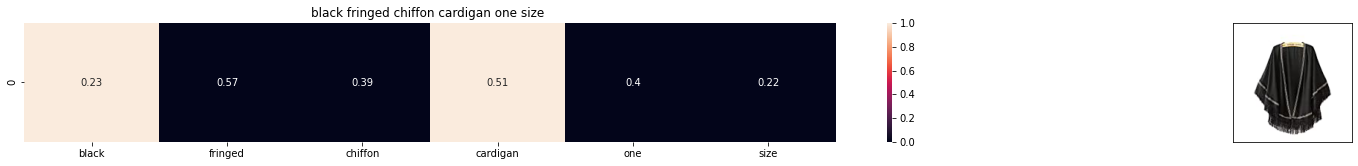

ASIN : B010AMAMLY
BRAND : HP-LEISURE
Eucliden distance from the given image : 1.2463648318197242


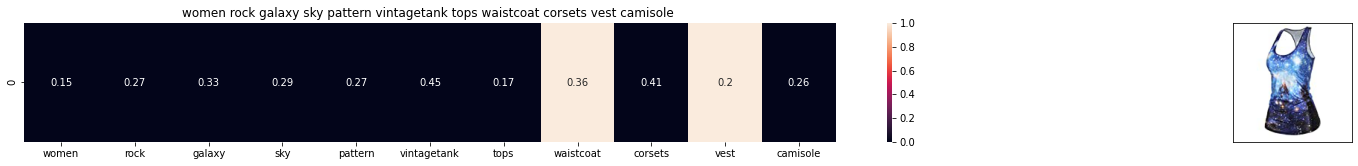

ASIN : B011R13M1O
BRAND : Huayang
Eucliden distance from the given image : 1.2479129830677684


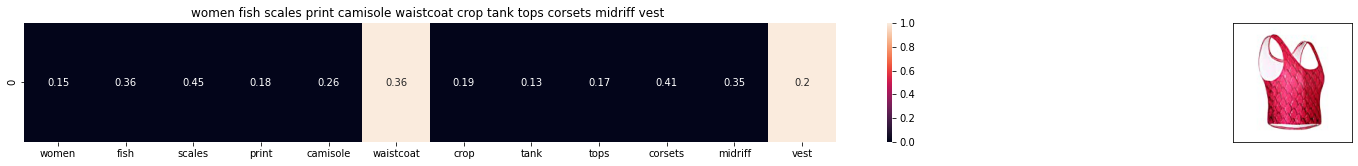

ASIN : B011R13BDS
BRAND : Huayang
Eucliden distance from the given image : 1.247961302381963


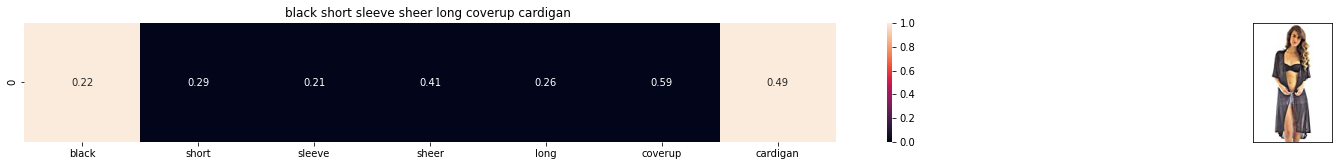

ASIN : B01GIP26MA
BRAND : Luxury Divas
Eucliden distance from the given image : 1.2521865818430968


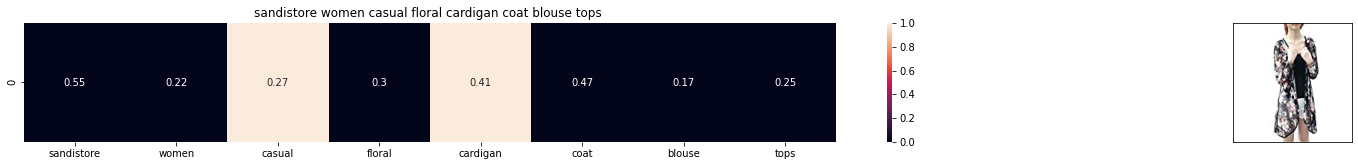

ASIN : B01AVX8IOU
BRAND : Sandistore
Eucliden distance from the given image : 1.2527438390346828


In [57]:
def tfidf_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

  
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)